## Group Report

## Introduction

For our data analysis, we will look at the two predictors of resting blood pressure and maximum heart rate. High resting blood pressure has been shown to cause heart disease in several ways, such as left ventricular hypertrophy, which can reduce the function of the heart. 120/80 is the optimal blood pressure of humans. Maximum heart rate achieved during exercise has been demonstrated to be inversely linked to the chances of one developing heart disease as it represents the fitness of one's heart and the ability to handle exercise. Therefore, our question is, how does resting blood pressure and maximum heart rate influence the diagnosis of heart disease, and are they major contributors? 
    
We’re using preprocessed data from the Cleveland database on heart disease,  originally containing 76 attributes, but we chose from a subset of 14. The 14 attributes include ‘age’, ‘sex’, ‘cp’ or chest pain, ‘trestbps’ or resting blood pressure on admission to the hospital, ‘chol’ or serum cholesterol, ‘fbs’ or fasting blood sugar 120 mg/dl, ‘restecg’ or resting electrocardiographic results, ‘thalac’ or maximum heart rate achieved, ‘exang’ or exercise induced angina, ’oldpeak’ or ST depression induced by exercise relative to rest, ‘slope’ the slope of the peak exercise ST segment, ‘ca’ or number of major vessels (0-3) colored by fluorosopy, ‘thal’: 3 = normal; 6 = fixed defect; 7 = reversible defect, and ‘num’ or diagnosis of heart disease. 


## Methods and Results

In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#read data
url<-"https://raw.githubusercontent.com/gracieS02/group_proposal_data/main/processed.cleveland.data?token=GHSAT0AAAAAACPGZWSBYOQE5DMJQJJQS2SAZPIZ32A"
download.file(url, "processed_cleveland.csv")

#rename columns & cleaning
cleveland_data <- read_csv("processed_cleveland.csv", 
                           col_name = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

#finding elements
elements <- cleveland_data == "?"

#replacing elements with NA
is.na(cleveland_data) <- elements

#finalizing tidying steps; factoring diagnosis
cleveland_data_cleaned <- mutate(cleveland_data, diagnose = ifelse(is.na(num), NA, (num > 0)), diagnose = as.factor(diagnose))

cleveland_data_cleaned


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnose
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,TRUE
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,FALSE


In [3]:
#splitting the dataframe into training and testing sets
cleveland_split <- initial_split(cleveland_data_cleaned, prop = 0.75, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

#counting the number of rows per split to ensure it was split correctly
nrow(cleveland_training)
nrow(cleveland_testing)

[1] 226

[1] 77

In [4]:
#summarizing the data set!

cleveland_summary <-cleveland_training |>
                    group_by(diagnose) |>
                    summarize( min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach), 
                              min_trestbps = min(trestbps), max_trestbps = max(trestbps), mean_trestbps = mean(trestbps),
                              number_of_patients = n())
                    

cleveland_summary

diagnose,min_thalach,max_thalach,mean_thalach,min_trestbps,max_trestbps,mean_trestbps,number_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,105,202,158.8629,94,180,128.9919,124
TRUE,88,195,140.3529,100,192,133.8529,102


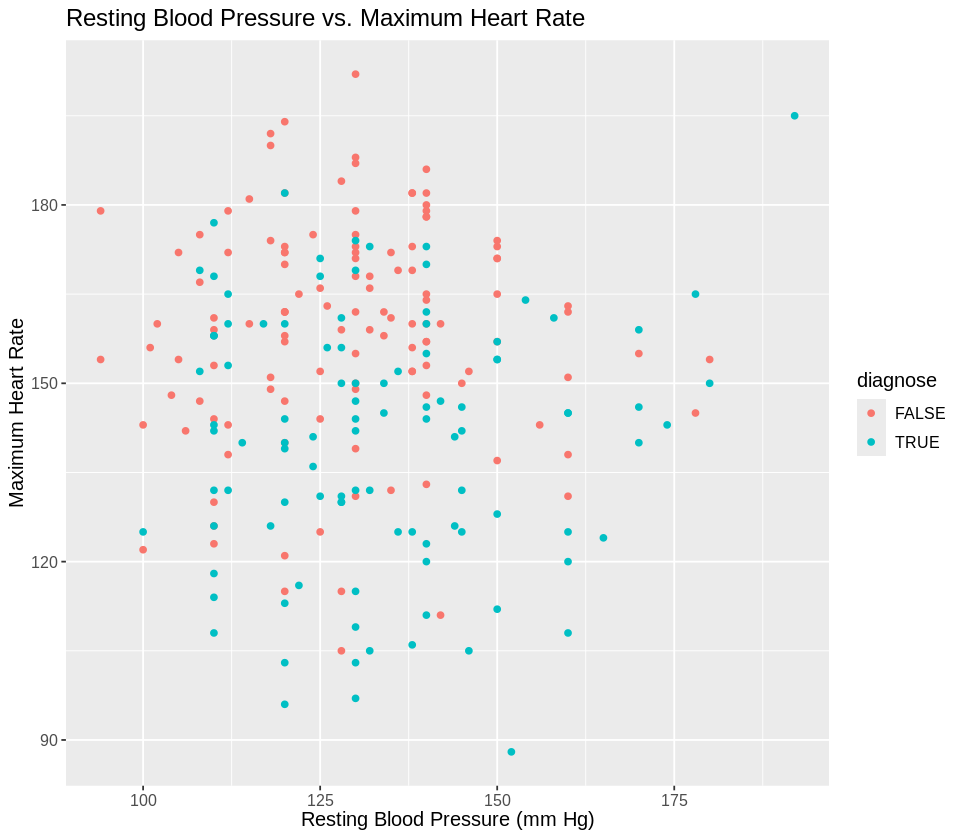

In [5]:
#plot a visualization of training data
options(repr.plot.width = 8, repr.plot.height = 7)

bp_thalach_plot <-ggplot(cleveland_training, aes(x=trestbps, y=thalach, color=diagnose)) +
                  geom_point() +
                  xlab("Resting Blood Pressure (mm Hg)") +
                  ylab("Maximum Heart Rate") +
                  ggtitle("Resting Blood Pressure vs. Maximum Heart Rate") +
                  theme(text = element_text(size = 12)) 
      

bp_thalach_plot


In [19]:
#finding the best k value
set.seed(999)

#recipe and scaling of data for k nearest neighbours
cleve_recipe <- recipe(diagnose ~ trestbps + thalach, data=cleveland_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 

#model specification (k nearest neighbours)
cleve_tune <- nearest_neighbor(weight_func="rectangular", neighbors= tune()) |>
            set_engine("kknn") |>
            set_mode("classification") 

#5 fold cross validation
cleve_vfold <- vfold_cv(cleveland_training, v=5, strata = diagnose)

#fitting the knn model and including the fold validation

grid_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

cleve_fit <- workflow() |>
            add_recipe(cleve_recipe) |>
            add_model(cleve_tune) |>
            tune_grid(resamples=cleve_vfold, grid=grid_vals) |>
            collect_metrics()

accuracy <- cleve_fit |>
            filter(.metric=="accuracy") |>
            arrange(desc(mean)) |>
            select(neighbors, mean) |>
            head(5)
    

accuracy


neighbors,mean
<dbl>,<dbl>
66,0.7078612
21,0.7033202
61,0.6990690
56,0.6989679
36,0.6985815


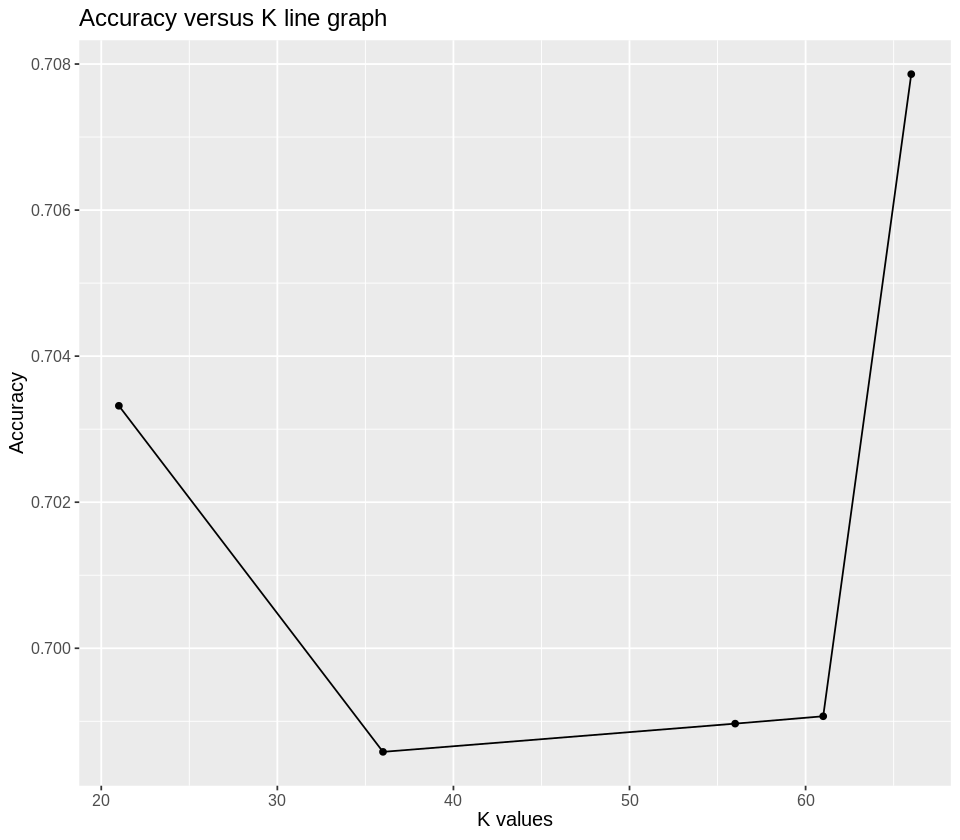

In [23]:
#plot determining best k value
options(repr.plot.width = 8, repr.plot.height = 7)

accuracy_vs_k <-ggplot(accuracy, aes(x=neighbors, y=mean)) +
                geom_point() + geom_line() +
                labs(x="K values", y="Accuracy") +
                ggtitle("Accuracy versus K line graph") +
                theme(text = element_text(size = 12)) 

accuracy_vs_k

## Discussion

## References